<a href="https://colab.research.google.com/github/JaminUbuntu/IBOK_NLP_2-CW/blob/main/choice_IBOK_NLP_DL_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 18.9 MB/s eta 0:00:00


In [4]:
pip install transformers

In [5]:
pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 8.2 MB/s eta 0:00:00


# WANDB Setup

In [6]:
pip install wandb

In [7]:
import wandb
wandb.login(key="695e5458c9c7c75621c0c11465575fbb0b1e7b5f")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeal2shine (zeal2shine-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    report_to="wandb",        # enables W&B logging
    run_name="bert-twitter-sentiment",  # optional: your custom run name
)

In [9]:
pip install datasets

In [10]:
pip install tensorflow

# Importing Libraries and Loading Files

In [103]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import TensorDataset
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from transformers import TFBertForSequenceClassification
import tensorflow as tf

In [66]:
# Configuring visual settings
sb.set(style="whitegrid")

Make a list of the uploaded files

In [67]:
# Define paths to the uploaded files

file_path_1 = "/content/SemEval2017-task4-test.subtask-A.english.txt"
file_path_2 ="/content/twitter-2015train-A.txt"

Function to read each line of text

In [68]:
# Load and preprocess a single file
# Load Dataset
data_1 = []
with open(file_path_1, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            tweet_id, label, text = parts
            data_1.append((text, label))
df1 = pd.DataFrame(data_1, columns=['text', 'label'])

# Load Dataset 2
data_2 = []
with open(file_path_2, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            tweet_id, label, text = parts
            data_2.append((text, label))
df2 = pd.DataFrame(data_2, columns=['text', 'label'])

In [69]:
# Setup counts of the distribution to eneable plots
print("Dataset 1 - Raw Sentiment Distribution:")
print(df1['label'].value_counts())

print("\nDataset 2 - Raw Sentiment Distribution:")
print(df2['label'].value_counts())

Dataset 1 - Raw Sentiment Distribution:
label
neutral     5937
negative    3972
positive    2375
Name: count, dtype: int64

Dataset 2 - Raw Sentiment Distribution:
label
neutral     253
positive    170
negative     66
Name: count, dtype: int64


In [70]:
print(df1.info()),
print("\n")
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12284 entries, 0 to 12283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12284 non-null  object
 1   label   12284 non-null  object
dtypes: object(2)
memory usage: 192.1+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    489 non-null    object
 1   label   489 non-null    object
dtypes: object(2)
memory usage: 7.8+ KB
None


In [71]:
df1.head()

,text,label
0,#ArianaGrande Ari By Ariana Grande 80% Full ht...,neutral
1,Ariana Grande KIIS FM Yours Truly CD listening...,positive
2,Ariana Grande White House Easter Egg Roll in W...,positive
3,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,positive
4,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,neutral


In [72]:
df2.head()

,text,label
0,I forgot how sad the first episode of the 5th ...,negative
1,Oct. 2 is almost too far away for me to wait f...,negative
2,"""(OFF TOPIC) - there is only 3 episodes on the...",neutral
3,"""@iheardavoicesay is finally catching up to me...",neutral
4,"""I downloaded the first season of #Dexter, gon...",neutral


In [73]:
print(df1.sample(3))

                                                    text     label
177    Barcelona are considering a move for Chelsea's...   neutral
975    Check out @ScissorSister2 great  #MannequinCha...  positive
11818  https://t.co/76pO1OgLm1 Wyoming voter Registra...   neutral


In [74]:
count_df1 = df1['label'].value_counts()

count_df1

,count
label,
neutral,5937
negative,3972
positive,2375


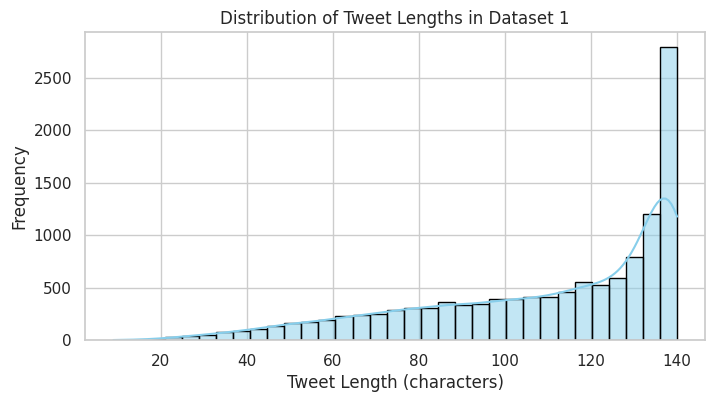

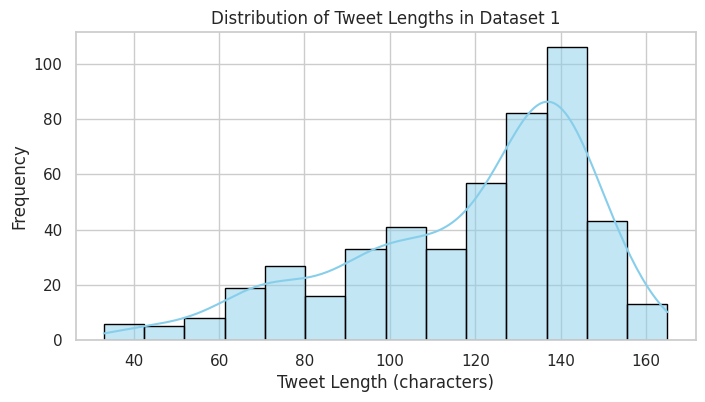

In [75]:
# Calculate text length for each dataset
df1['text_length'] = df1['text'].apply(len)
df2['text_length'] = df2['text'].apply(len)

# Plot distribution of text lengths for Dataset 1
plt.figure(figsize=(8, 4))
sb.histplot(df1['text_length'], kde=True, color="skyblue", edgecolor='black')
plt.title('Distribution of Tweet Lengths in Dataset 1')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

print("\n")

# Plot distribution of text lengths for Dataset 1
plt.figure(figsize=(8, 4))
sb.histplot(df2['text_length'], kde=True, color="skyblue", edgecolor='black')
plt.title('Distribution of Tweet Lengths in Dataset 1')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()


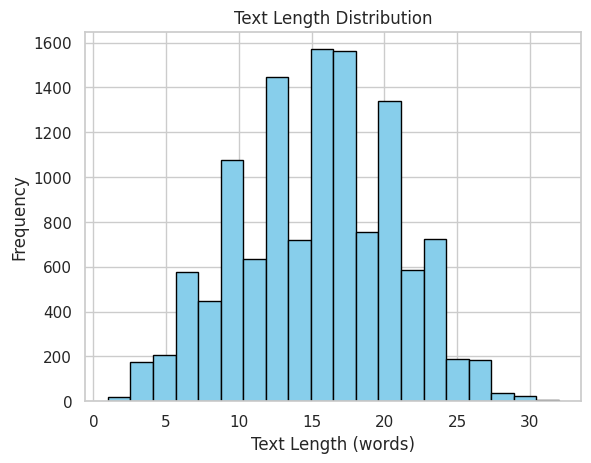

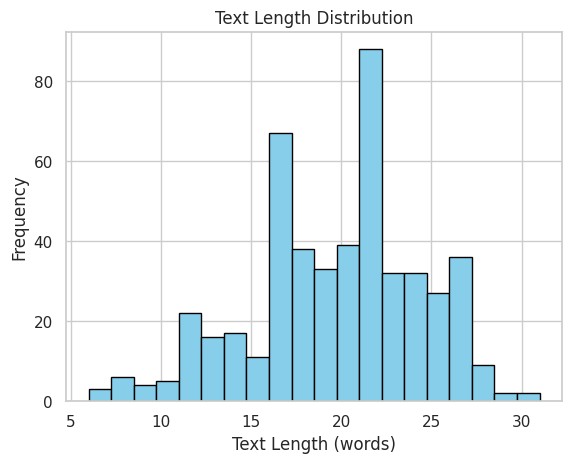

In [76]:
# Visualizing text length distribution
df1['text_length'] = df1['text'].apply(lambda x: len(x.split()))
plt.hist(df1['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

print("\n")

# Visualizing text length distribution
df2['text_length'] = df2['text'].apply(lambda x: len(x.split()))
plt.hist(df2['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

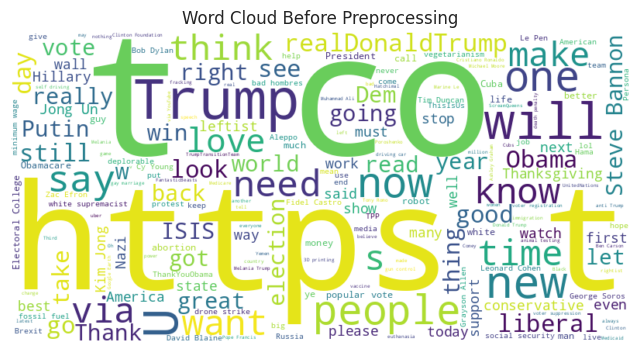

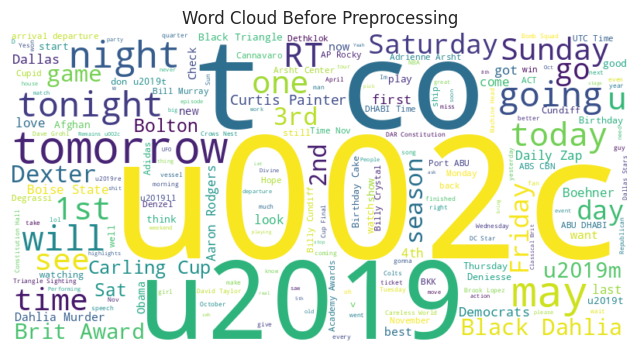

In [77]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df1['text']))
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Before Preprocessing')
plt.show()

print("\n")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df2['text']))
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Before Preprocessing')
plt.show()

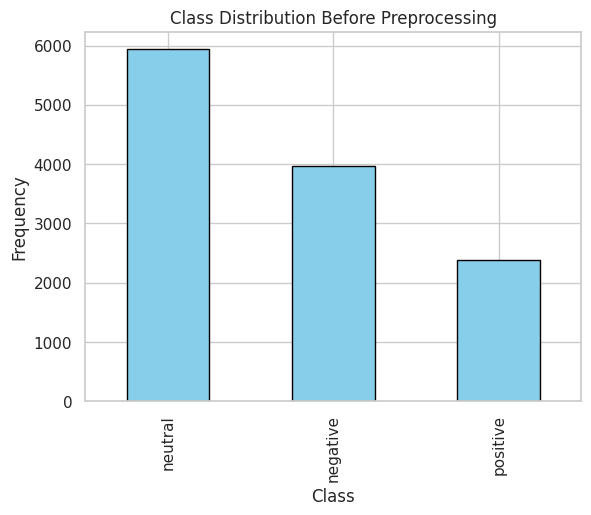

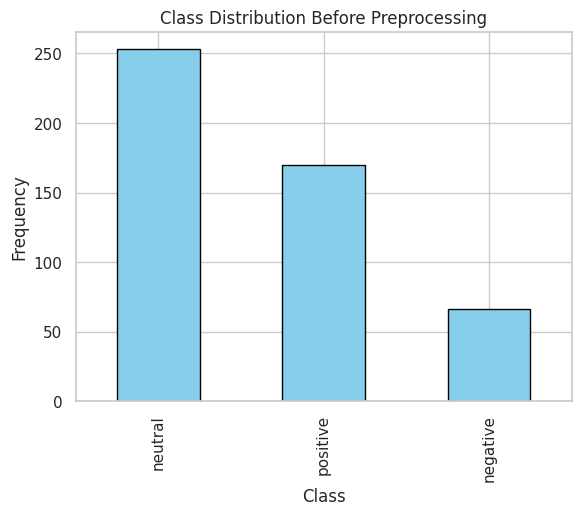

In [78]:
# Example for visualizing class distribution (for labeled data)
df1['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution Before Preprocessing')
plt.show()

print("\n")

df2['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution Before Preprocessing')
plt.show()

In [79]:
count_df2 = df2['label'].value_counts()

count_df2

,count
label,
neutral,253
positive,170
negative,66


In [80]:
df1.describe()

,text_length
count,12284.000000
mean,15.424373
std,5.408154
min,1.000000
25%,11.000000
50%,16.000000
75%,20.000000
max,32.000000


In [81]:
df2.describe()

,text_length
count,489.000000
mean,19.652352
std,4.701957
min,6.000000
25%,17.000000
50%,20.000000
75%,23.000000
max,31.000000


Checking for Null and Duplicate Values

In [82]:
def check_data_health(df, name="Dataset"):
    print(f"\n{name} - Missing Values:")
    print(df.isnull().sum())
    print(f"\n{name} - Duplicate Rows: {df.duplicated().sum()}")

check_data_health(df1, "text")
check_data_health(df2, "text")
check_data_health(df1, "label")
check_data_health(df2, "label")


text - Missing Values:
text           0
label          0
text_length    0
dtype: int64

text - Duplicate Rows: 0

text - Missing Values:
text           0
label          0
text_length    0
dtype: int64

text - Duplicate Rows: 0

label - Missing Values:
text           0
label          0
text_length    0
dtype: int64

label - Duplicate Rows: 0

label - Missing Values:
text           0
label          0
text_length    0
dtype: int64

label - Duplicate Rows: 0


In [83]:
df1

,text,label,text_length
0,#ArianaGrande Ari By Ariana Grande 80% Full ht...,neutral,11
1,Ariana Grande KIIS FM Yours Truly CD listening...,positive,13
2,Ariana Grande White House Easter Egg Roll in W...,positive,11
3,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,positive,19
4,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,neutral,12
...,...,...,...
12279,@dansen17 update: Zac Efron kissing a puppy ht...,positive,8
12280,#zac efron sex pic skins michelle sex https://...,neutral,8
12281,First Look at Neighbors 2 with Zac Efron Shirt...,neutral,12
12282,zac efron poses nude #lovely libra porn https:...,neutral,8


In [84]:
df2

,text,label,text_length
0,I forgot how sad the first episode of the 5th ...,negative,17
1,Oct. 2 is almost too far away for me to wait f...,negative,16
2,"""(OFF TOPIC) - there is only 3 episodes on the...",neutral,21
3,"""@iheardavoicesay is finally catching up to me...",neutral,26
4,"""I downloaded the first season of #Dexter, gon...",neutral,18
...,...,...,...
484,"""Cant wait to see \""""""""Flight\"""""""" on Saturday...",positive,22
485,Gotta go see Flight tomorrow Denzel is the gre...,positive,11
486,Hey I wanna see Flight tomorrow with Denzel ol...,positive,11
487,That movie Flight with Denzel looks really goo...,positive,15


Label Encoding

In [85]:
# Combine both datasets to fit encoder
all_labels = list(df1['label']) + list(df2['label'])  # df_train = your main dataset, df_val = validation

# Fit once on all available labels
le = LabelEncoder()
le.fit(all_labels)

# Now transform separately
df1['label_enc'] = le.transform(df1['label'])
df2['label_enc'] = le.transform(df2['label'])

In [86]:
df1

,text,label,text_length,label_enc
0,#ArianaGrande Ari By Ariana Grande 80% Full ht...,neutral,11,1
1,Ariana Grande KIIS FM Yours Truly CD listening...,positive,13,2
2,Ariana Grande White House Easter Egg Roll in W...,positive,11,2
3,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,positive,19,2
4,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,neutral,12,1
...,...,...,...,...
12279,@dansen17 update: Zac Efron kissing a puppy ht...,positive,8,2
12280,#zac efron sex pic skins michelle sex https://...,neutral,8,1
12281,First Look at Neighbors 2 with Zac Efron Shirt...,neutral,12,1
12282,zac efron poses nude #lovely libra porn https:...,neutral,8,1


In [87]:
df2

,text,label,text_length,label_enc
0,I forgot how sad the first episode of the 5th ...,negative,17,0
1,Oct. 2 is almost too far away for me to wait f...,negative,16,0
2,"""(OFF TOPIC) - there is only 3 episodes on the...",neutral,21,1
3,"""@iheardavoicesay is finally catching up to me...",neutral,26,1
4,"""I downloaded the first season of #Dexter, gon...",neutral,18,1
...,...,...,...,...
484,"""Cant wait to see \""""""""Flight\"""""""" on Saturday...",positive,22,2
485,Gotta go see Flight tomorrow Denzel is the gre...,positive,11,2
486,Hey I wanna see Flight tomorrow with Denzel ol...,positive,11,2
487,That movie Flight with Denzel looks really goo...,positive,15,2


Feature Extraction

In [88]:
X1 = df1['text']
y1 = df1['label_enc']

X2 = df2['text']
y2 = df2['label_enc']

Preparing function for label encoding for BERT and BiLSTM

In [89]:
def prepare_datasets_split_and_encode(X1, y1, X2, y2):


    # Split dataset1 into 70% train and 30% test
    train_texts, test_texts, train_labels, test_labels = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)

    # Combine all labels to fit one LabelEncoder
    all_labels = pd.concat([train_labels, test_labels, y2], ignore_index=True) # using pd.concat

    le = LabelEncoder()
    le.fit(all_labels)

    # Encode labels
    train_y = le.transform(train_labels)
    test_y = le.transform(test_labels)
    val_y = le.transform(y2)

    # Create mappings
    label_map = dict(zip(le.classes_, le.transform(le.classes_)))
    inv_label_map = {v: k for k, v in label_map.items()}

    return {
        'train_texts': train_texts,
        'train_labels': train_y,
        'test_texts': test_texts,
        'test_labels': test_y,
        'val_texts': X2,
        'val_labels': val_y,
        'label_map': label_map,
        'inv_label_map': inv_label_map,
        'label_encoder': le
    }

In [90]:
# Call the function to get the split datasets
datasets = prepare_datasets_split_and_encode(X1, y1, X2, y2)

print("Train set size:", len(datasets['train_texts']))
print("Test set size:", len(datasets['test_texts']))
print("Validation set size:", len(datasets['val_texts']))
print("Label Encoding:", datasets['label_map'])

Train set size: 8598
Test set size: 3686
Validation set size: 489
Label Encoding: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2)}


In [91]:
# Access the train_texts, test_texts, and val_texts from the datasets dictionary
train_texts = datasets['train_texts']
test_texts = datasets['test_texts']
val_texts = datasets['val_texts']

In [92]:
# Clean tweet text
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)  # remove urls
    tweet = re.sub(r"\@\w+|\#", '', tweet)  # remove mentions and hashtags
    tweet = re.sub(r"[^\w\s]", '', tweet)  # remove punctuation
    tweet = re.sub(r"\d+", '', tweet)  # remove numbers
    tweet = re.sub(r"\s+", ' ', tweet).strip()  # remove extra spaces
    return tweet

In [93]:
train_texts = [clean_tweet(t) for t in train_texts]
test_texts = [clean_tweet(t) for t in test_texts]
val_texts = [clean_tweet(t) for t in val_texts]

In [108]:
# Get original string labels from train set
train_label_ints = datasets['train_labels']
label_names = list(datasets['label_map'].keys())

# Compute weights (ensures rarer classes get higher weight)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_label_ints),
    y=train_label_ints
)

# Map class index → weight
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.030935251798561), 1: np.float64(0.6896053897978826), 2: np.float64(1.7244283995186522)}


In [112]:
# You already have these
label_map = datasets['label_map']
inv_map = datasets['inv_label_map']

In [113]:
# Convert integer labels to class names
train_label_names = [inv_map[i] for i in datasets['train_labels']]

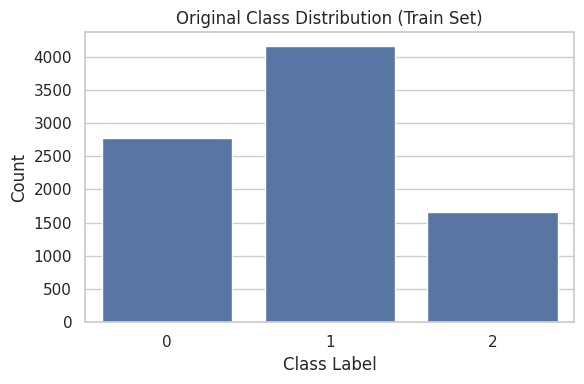

In [115]:
# Count class occurrences
label_df = pd.DataFrame({'Sentiment': train_label_names})
plt.figure(figsize=(6,4))
sb.countplot(data=label_df, x='Sentiment', order=sorted(label_map.keys()))
plt.title("Original Class Distribution (Train Set)")
plt.ylabel("Count")
plt.xlabel("Class Label")
plt.tight_layout()
plt.show()

Visualizing the Class WEIGHTS

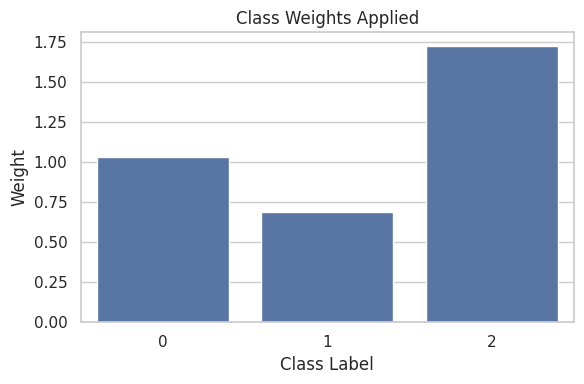

In [118]:
# Optional: visualize class weights
weight_df = pd.DataFrame.from_dict(class_weight_dict, orient='index', columns=['Weight'])
weight_df['Class'] = weight_df.index.map(inv_map)
plt.figure(figsize=(6,4))
sb.barplot(data=weight_df, x='Class', y='Weight', order=sorted(label_map.keys()))
plt.title("Class Weights Applied")
plt.ylabel("Weight")
plt.xlabel("Class Label")
plt.tight_layout()
plt.show()

In [124]:
datasets['clean_text'] = train_texts
datasets['label_enc'] = train_label_ints
#datasets['label_names'] = train_label_names
#datasets['class_weights'] = class_weight_dict
#datasets['label_map'] = label_map
#datasets['inv_label_map'] = inv_map
#datasets['label_encoder'] = le
#datasets['label_df'] = label_df
#datasets['class_weight_dict'] = class_weight_dict
#datasets['weight_df'] = weight_df
#datasets['train_texts'] = train_texts
#datasets['test_texts'] = test_texts
datasets['val_texts'] = val_texts

Tokenize using BERT Tokenizer

In [127]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 64

def encode_bert_inputs(texts, labels):
    input_ids, masks = [], []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        masks.append(encoded['attention_mask'])

    return torch.cat(input_ids), torch.cat(masks), torch.tensor(labels)

# Encode data
train_inputs, train_masks, train_labels = encode_bert_inputs(datasets['clean_text'], datasets['label_enc'])
val_inputs, val_masks, val_labels = encode_bert_inputs(datasets['val_texts'], datasets['val_labels'])

Convert Encoded Tensors to HuggingFace Dataset

In [128]:
train_dataset = Dataset.from_dict({
    'input_ids': train_inputs.numpy().tolist(),
    'attention_mask': train_masks.numpy().tolist(),
    'labels': train_labels.numpy().tolist()
})

val_dataset = Dataset.from_dict({
    'input_ids': val_inputs.numpy().tolist(),
    'attention_mask': val_masks.numpy().tolist(),
    'labels': val_labels.numpy().tolist()
})


Define compute_metrics (Outside Trainer)

In [129]:
# Define metrics

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


Load Model + Trainer Cofig

In [130]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="wandb",
    run_name="bert-twitter-sentiment"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
# Encode test data
test_inputs, test_masks, test_labels = encode_bert_inputs(test_df['clean_text'], test_df['label_enc'])

# Convert to HuggingFace dataset
from datasets import Dataset

test_dataset = Dataset.from_dict({
    'input_ids': test_inputs.numpy().tolist(),
    'attention_mask': test_masks.numpy().tolist(),
    'labels': test_labels.numpy().tolist()
})

In [ ]:
# Predict using the fine-tuned model
predictions = trainer.predict(test_dataset)

# Extract predicted labels
pred_labels = predictions.predictions.argmax(-1)

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.39      0.53      3972
     neutral       0.60      0.67      0.63      5937
    positive       0.50      0.80      0.61      2375

    accuracy                           0.60     12284
   macro avg       0.64      0.62      0.59     12284
weighted avg       0.65      0.60      0.60     12284



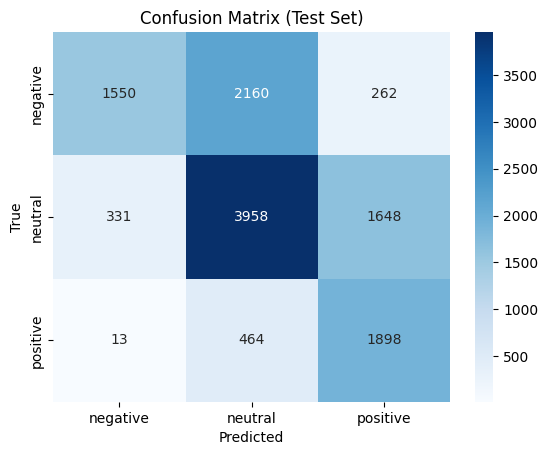

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [ ]:
bert_precision, bert_recall, bert_f1, bert_support = precision_recall_fscore_support(test_labels, pred_labels, average='weighted', zero_division=0)

In [ ]:
bert_accuracy = accuracy_score(test_labels, pred_labels)

Begin Implementation of BiLSTM

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

In [ ]:
# Setup  Parameters
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

In [ ]:
# Tokenize using Keras
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(train_df['clean_text'])

In [ ]:
# Convert texts to sequences and pad them
def prepare_sequences(df, tokenizer):
    seqs = tokenizer.texts_to_sequences(df['clean_text'])
    padded = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    labels = to_categorical(df['label_enc'], num_classes=3)
    return padded, labels

In [ ]:
X_train_lstm, y_train_lstm = prepare_sequences(train_df, keras_tokenizer)
X_val_lstm, y_val_lstm = prepare_sequences(val_df, keras_tokenizer)
X_test_lstm, y_test_lstm = prepare_sequences(test_df, keras_tokenizer)

Load GloVe Embeddings

In [ ]:
# Load GloVe embeddings
embedding_index = {}
with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
# Create embedding matrix
word_index = keras_tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Building the BiLSTM Model

In [ ]:
# Build BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=num_words,
                           output_dim=EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(3, activation='softmax'))

Compiling the Model

In [ ]:
bilstm_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
# Return model and data for training externally
def display_dataframe_to_user(name, dataframe):
    print(f"{name}:\n{dataframe}\n")

display_dataframe_to_user(name="BiLSTM Data Shapes", dataframe=pd.DataFrame({
    "Train Shape": [X_train_lstm.shape],
    "Val Shape": [X_val_lstm.shape],
    "Test Shape": [X_test_lstm.shape]
}))

BiLSTM Data Shapes:
  Train Shape   Val Shape   Test Shape
0  (6489, 50)  (2000, 50)  (12284, 50)



In [ ]:
# Train the BiLSTM model
history = bilstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.5020 - loss: 0.9909 - val_accuracy: 0.5400 - val_loss: 0.9323
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.5804 - loss: 0.8771 - val_accuracy: 0.5690 - val_loss: 0.8912
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.6029 - loss: 0.8389 - val_accuracy: 0.5765 - val_loss: 0.8824
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.6178 - loss: 0.8127 - val_accuracy: 0.5620 - val_loss: 0.8911
Epoch 5/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.6303 - loss: 0.8000 - val_accuracy: 0.5770 - val_loss: 0.8906


Plot the Accuracy

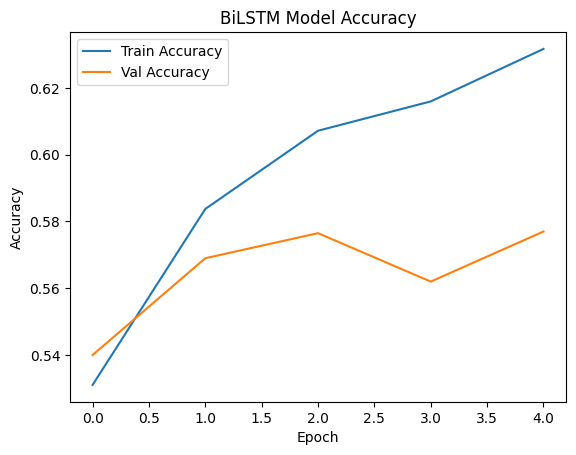

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plot the Loss

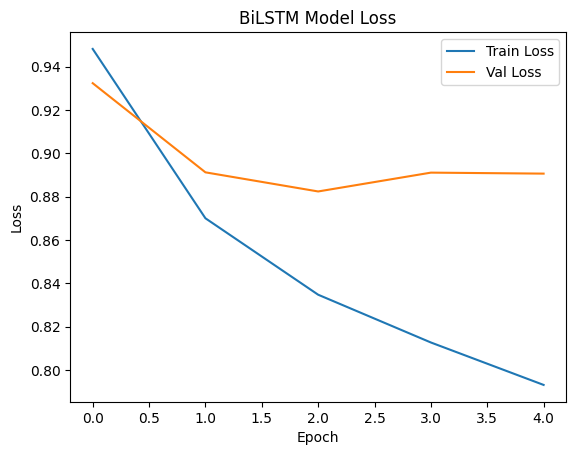

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate on Test Data

In [ ]:
# Evaluate on test data
loss, accuracy = bilstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5423 - loss: 0.9124
Test Accuracy: 0.5210


In [ ]:
# Predict class probabilities
y_pred_probs = bilstm_model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_lstm, axis=1)

384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step


              precision    recall  f1-score   support

    negative       0.68      0.35      0.46      3972
     neutral       0.57      0.54      0.55      5937
    positive       0.39      0.77      0.52      2375

    accuracy                           0.52     12284
   macro avg       0.55      0.55      0.51     12284
weighted avg       0.57      0.52      0.52     12284



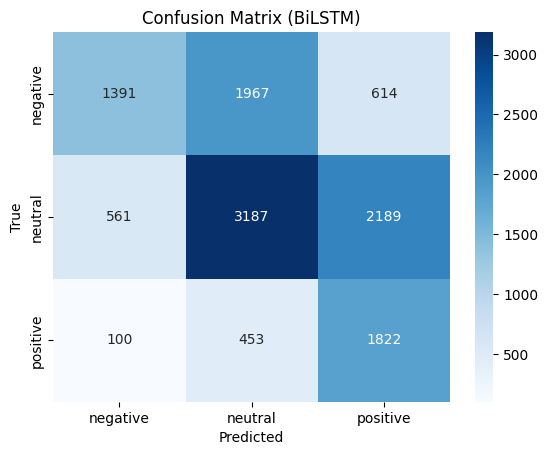

In [ ]:
# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))



# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix (BiLSTM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Calculate BiLSTM F1-score (weighted average)
bilstm_precision, bilstm_recall, bilstm_f1, bilstm_support = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted', zero_division=0)

In [ ]:
bilstm_accuracy = accuracy_score(y_true_classes, y_pred_classes)

In [ ]:
# Store results in a dictionary for side-by-side view
results_comparison = {
    "Model": ["BiLSTM", "BERT"],
    "Accuracy": [accuracy, bert_accuracy],
    "F1 Score": [bilstm_f1, bert_f1],
    "Precision": [bilstm_precision, bert_precision],
    "Recall": [bilstm_recall, bert_recall],
    "Support": [bilstm_support, bert_support]
}

# Convert to DataFrame
results_df = pd.DataFrame(results_comparison)
display(results_df)

,Model,Accuracy,F1 Score,Precision,Recall,Support
0,BiLSTM,0.521003,0.516836,0.570068,0.521003,None
1,BERT,0.602898,0.595186,0.651618,0.602898,None


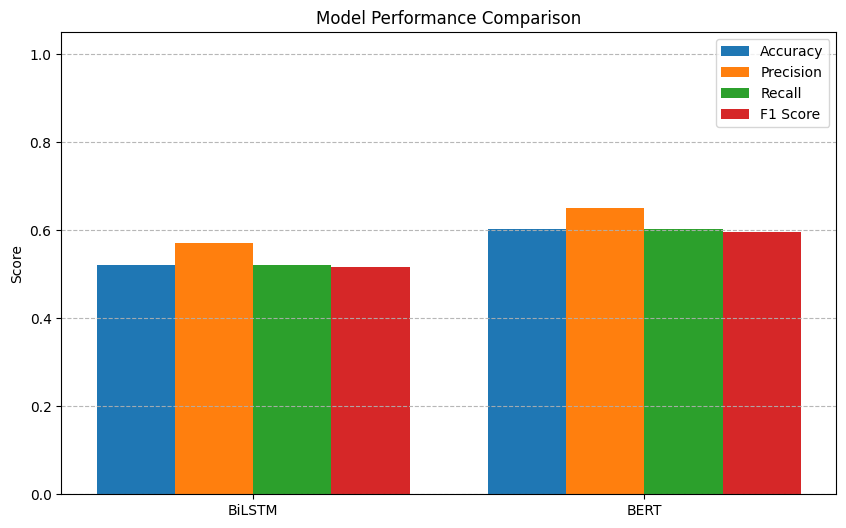

In [ ]:
# Example placeholder values – replace with your actual metrics
models = ['BiLSTM', 'BERT']
accuracy = [bilstm_accuracy, bert_accuracy]
f1 = [bilstm_f1, bert_f1]
precision = [bilstm_precision, bert_precision]
recall = [bilstm_recall, bert_recall]

# Plot grouped bar chart
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
ax.bar(x - 0.5*width, precision, width, label='Precision')
ax.bar(x + 0.5*width, recall, width, label='Recall')
ax.bar(x + 1.5*width, f1, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim([0, 1.05])
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

Adding generated noise in form of linguistic typo

In [ ]:
import nlpaug.augmenter.char as nac
import random

# Define the augmenter to simulate keyboard typos
typo_aug = nac.KeyboardAug()

# Apply noise to a list of texts
def apply_typo_noise(texts, n=1):
    # n=1 means one noisy version per text
    #noisy_texts = [typo_aug.augment(text, n=n)[0] for text in texts]
    noisy_texts = [aug for text in texts for aug in typo_aug.augment(text, n=n)]
    return noisy_texts

# Apply to the test set
noisy_texts = apply_typo_noise(test_df['clean_text'].tolist())

In [ ]:
noisy_texts

['arisnagrAjd4 ari by ariana nranre full singer avtrfws',
 'ariana gramdd ku*s fm yours truly cd listening pX#ty in burvzn, arianagrande',
 'ariana grande white house eaztRr egg rKli in washington xrixnWvrande',
 'cd mIeics Zr(ana Trabde sweet l9me candy oz ml sea,ex in box authenic new',
 'side to side sidetoside Z3ianag5anEe musically comunidadgay lgvh loYn',
 'gai5sprAy Iivw previews at the macys thanksgiving day parade arOanaVrajCe tFlevisikbnbV',
 'lindsaylohan is f3eloGg thankful af6Wr blasting ar&aJagEands for wearing toomuch',
 'i hAHe her but i love her zonhs damJ&t _arianagrande',
 'atkana g3anRe right there ft big C3Anアリアナ arianagrande',
 'which one would you pretdr to listSM to for a qhoPe day i coukC never choose qriaJagrWgde Jht9you s(detICide songs poll',
 'bLotT baby a3lariaGzgraMde princessari bootybaby vahgerous@ImanroHr dangerouswoman',
 'lindsaylohan backs out of a kettering hKliExy aOp2araJce just after tUr8wiMg shade at a#ianwhranWe li,*',
 'my ifolc are littlemix

In [ ]:
for original, noisy in zip(test_df['clean_text'][:5], noisy_texts[:5]):
    print(f"Original: {original}")
    print(f"Noisy   : {noisy}")
    print("—" * 50)

Original: arianagrande ari by ariana grande full singer actress
Noisy   : arisnagrAjd4 ari by ariana nranre full singer avtrfws
——————————————————————————————————————————————————
Original: ariana grande kiis fm yours truly cd listening party in burbank arianagrande
Noisy   : ariana gramdd ku*s fm yours truly cd listening pX#ty in burvzn, arianagrande
——————————————————————————————————————————————————
Original: ariana grande white house easter egg roll in washington arianagrande
Noisy   : ariana grande white house eaztRr egg rKli in washington xrixnWvrande
——————————————————————————————————————————————————
Original: cd musics ariana grande sweet like candy oz ml sealed in box authenic new
Noisy   : cd mIeics Zr(ana Trabde sweet l9me candy oz ml sea,ex in box authenic new
——————————————————————————————————————————————————
Original: side to side sidetoside arianagrande musically comunidadgay lgbt lotb
Noisy   : side to side sidetoside Z3ianag5anEe musically comunidadgay lgvh loYn
————————

Re-encode noisy data for BERT

In [ ]:
# Reuse the BERT tokenizer
noisy_inputs, noisy_masks, noisy_labels = encode_bert_inputs(noisy_test_texts, test_df['label_enc'])


# Create HuggingFace Dataset
noisy_bert_dataset = Dataset.from_dict({
    'input_ids': noisy_inputs.numpy().tolist(),
    'attention_mask': noisy_masks.numpy().tolist(),
    'labels': noisy_labels.numpy().tolist()
})

Predict with BERT on Noisy Data

In [ ]:
# Evaluate model robustness to noise
noisy_bert_preds = trainer.predict(noisy_bert_dataset)

from sklearn.metrics import classification_report

noisy_bert_labels = noisy_labels.numpy()
noisy_bert_pred_classes = noisy_bert_preds.predictions.argmax(-1)

print("BERT on Noisy Test Data")
print(classification_report(noisy_bert_labels, noisy_bert_pred_classes, target_names=le.classes_))

NameError: name 'trainer' is not defined